该Notebook实现了论文 [Federated Learning with Personalization Layers](https://arxiv.org/abs/1912.00818) 中的数据异质性划分方法，并基于 FedPer 策略完成个性化联邦实验。

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import secretflow as sf

# Check the version of your SecretFlow
print("The version of SecretFlow: {}".format(sf.__version__))

# In case you have a running secretflow runtime already.
sf.shutdown()

sf.init(["alice", "bob", "charlie"], address="local")
alice, bob, charlie = sf.PYU("alice"), sf.PYU("bob"), sf.PYU("charlie")

The version of SecretFlow: 1.3.0.dev20231206


2023-12-09 02:32:15,527	INFO worker.py:1538 -- Started a local Ray instance.


In [3]:
from secretflow.ml.nn.utils import BaseModule, TorchModel
from secretflow.ml.nn.fl.utils import metric_wrapper, optim_wrapper
from secretflow.ml.nn import FLModel
from torchmetrics import Accuracy, Precision
from secretflow.security.aggregation import SecureAggregator
from secretflow.utils.simulation.datasets import load_mnist
from torch import nn, optim
from torch.nn import functional as F

2023-12-09 02:32:20.191571: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-12-09 02:32:20.832637: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-12-09 02:32:20.832693: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-12-09 02:32:20.832698: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed proper

In [4]:
class SimpleCNN(BaseModule):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc = nn.Linear(32 * 8 * 8, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 32 * 8 * 8)
        x = self.fc(x)
        return x

为了实现论文中数据异质性的划分方法，依据secretflow/utils/simulation/datasets.py中加载数据集的方法写load_cifar10数据集加载方法，其中num_classes_per_client是每个客户端的随机数据集类别数，论文中取[4,8,10], 类别越少每个客户端数据集差异越明显, 每个客户端数据总量相同，如果某一类图像不够允许重复采样。

In [5]:
from typing import Dict, List, Tuple, Union
import numpy as np
from secretflow.data.ndarray import FedNdarray, PartitionWay
from secretflow.device.device.pyu import PYU
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torch.utils.data import DataLoader


def load_cifar10(
    parts: Union[List[PYU], Dict[PYU, Union[float, Tuple]]],
    batch_size: int = 1,
    is_torch: bool = True,
    num_classes_per_client=4,
) -> Tuple[Tuple[FedNdarray, FedNdarray], Tuple[FedNdarray, FedNdarray]]:
    """Load CIFAR-10 dataset to federated ndarrays.

    Args:
        parts: the data partitions.
        batch_size: Batch size for the DataLoader.
        is_torch: optional, return torch tensors if True. Default to True.
        num_classes_per_client: the random classes number of per client.

    Returns:
        A tuple consists of two tuples, (x_train, y_train) and (x_test, y_test).
    """
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )

    # Load CIFAR-10 training and testing sets
    trainset = CIFAR10(root="./data", train=True, download=True, transform=transform)
    testset = CIFAR10(root="./data", train=False, download=True, transform=transform)

    # Using DataLoader for Batch Processing
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
    testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

    # Convert DataLoader to a format that SecretFlow can handle
    train_data, train_labels = _convert_to_fedndarray(
        trainloader, parts, is_torch, num_classes_per_client
    )
    test_data, test_labels = _convert_to_fedndarray(
        testloader, parts, is_torch, num_classes_per_client
    )

    return ((train_data, train_labels), (test_data, test_labels))


def create_cifar10_ndarray(
    data, labels, parts, is_torch=False, num_classes_per_client=4
):
    assert len(data) == len(labels), "Data and labels must have the same length"
    class_indices = {i: np.where(labels == i)[0] for i in range(10)}

    # Class assigned to each PYU
    pyu_classes = {}
    total_samples = len(data)
    for idx, pyu in enumerate(parts.keys()):
        np.random.seed(idx)
        pyu_classes[pyu] = np.random.choice(10, num_classes_per_client, replace=False)

    # Assign data and labels to each PYU
    pyu_data = {}
    pyu_labels = {}
    for pyu, proportion in parts.items():
        pyu_sample_size = int(
            total_samples * proportion
        )  # Calculate the sample size for each PYU
        # Sample data from selected classes for each PYU
        indices = np.concatenate(
            [
                np.random.choice(
                    class_indices[cls],
                    size=pyu_sample_size // num_classes_per_client,
                    replace=True,
                )
                for cls in pyu_classes[pyu]
            ]
        )
        np.random.shuffle(indices)
        pyu_data[pyu] = data[indices]
        pyu_labels[pyu] = labels[indices]
        # Print the amount of data and random classes for each PYU
        print(
            f"the sample size of {pyu} is {len(pyu_data[pyu])}, random classes are {pyu_classes[pyu]}."
        )
        # print(pyu_labels[pyu][0].dtype)

    # Convert data and labels to FedNdarray
    data_fedndarray = FedNdarray(
        partitions={pyu: pyu(lambda arr: arr)(pyu_data[pyu]) for pyu in parts.keys()},
        partition_way=PartitionWay.HORIZONTAL,
    )

    labels_fedndarray = FedNdarray(
        partitions={pyu: pyu(lambda arr: arr)(pyu_labels[pyu]) for pyu in parts.keys()},
        partition_way=PartitionWay.HORIZONTAL,
    )

    return data_fedndarray, labels_fedndarray


def _convert_to_fedndarray(dataloader, parts, is_torch, num_classes_per_client):
    data_list = []
    label_list = []
    for data, label in dataloader:
        if is_torch:
            data = data.numpy()
            label = label.numpy()
        data_list.append(data)
        label_list.append(label)

    return create_cifar10_ndarray(
        np.concatenate(data_list),
        np.concatenate(label_list),
        parts=parts,
        is_torch=is_torch,
        num_classes_per_client=num_classes_per_client,
    )

这里使用两个客户端做演示，每个客户端数据量为10%，即5000训练集和1000验证集，客户端图像类别数为4。

In [6]:
(train_data, train_label), (test_data, test_label) = load_cifar10(
    parts={alice: 0.1, bob: 0.1},
    is_torch=True,
    num_classes_per_client=4,
)

loss_fn = nn.CrossEntropyLoss
optim_fn = optim_wrapper(optim.SGD, lr=0.01)
model_def = TorchModel(
    model_fn=SimpleCNN,
    loss_fn=loss_fn,
    optim_fn=optim_fn,
    metrics=[
        metric_wrapper(Accuracy, task="multiclass", num_classes=10, average="micro"),
        metric_wrapper(Precision, task="multiclass", num_classes=10, average="micro"),
    ],
)

Files already downloaded and verified
Files already downloaded and verified
the sample size of alice is 5000, random classes are [2 8 4 9].
the sample size of bob is 5000, random classes are [2 9 6 4].
the sample size of alice is 1000, random classes are [2 8 4 9].
the sample size of bob is 1000, random classes are [2 9 6 4].


先打印出模型结构来确认客户端个性层数量Kp，注意Kp和模型的层数不同，模型参数列表中倒数Kp层是个性层。默认Kp为2指定的是全连接层的weight和bias，即下方打印的fc.weight和fc.bias。

In [7]:
net = SimpleCNN()
for name, param in net.named_parameters():
    print(name, param.shape)

conv1.weight torch.Size([16, 3, 3, 3])
conv1.bias torch.Size([16])
conv2.weight torch.Size([32, 16, 3, 3])
conv2.bias torch.Size([32])
fc.weight torch.Size([10, 2048])
fc.bias torch.Size([10])


要使用FedPer策略，指定strategy='fed_per'，超参数Kp指定客户端个性化层的数量。

In [9]:
device_list = [alice, bob]
server = charlie
aggregator = SecureAggregator(server, [alice, bob])

# spcify params
fl_model = FLModel(
    server=server,
    device_list=device_list,
    model=model_def,
    aggregator=aggregator,
    strategy="fed_per",  # fl strategy
    # strategy='fed_avg_w',
    backend="torch",
    Kp=2,
)

INFO:root:Create proxy actor <class 'secretflow.security.aggregation.secure_aggregator._Masker'> with party alice.
INFO:root:Create proxy actor <class 'secretflow.security.aggregation.secure_aggregator._Masker'> with party bob.
INFO:root:Create proxy actor <class 'secretflow.ml.nn.fl.backend.torch.strategy.fed_per.PYUFedPer'> with party alice.
INFO:root:Create proxy actor <class 'secretflow.ml.nn.fl.backend.torch.strategy.fed_per.PYUFedPer'> with party bob.
(pid=2057089) 2023-12-09 02:37:14.925847: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
(pid=2057154) 2023-12-09 02:37:15.025396: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
(pid=2057089) 2023-12-09

模型训练，这里以16个epoch为例，选用不同策略后需要重新训练并画出结果。

In [10]:
history = fl_model.fit(
    train_data,
    train_label,
    validation_data=(test_data, test_label),
    epochs=16,
    batch_size=128,
    aggregate_freq=4,
)

INFO:root:FL Train Params: {'x': FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7f70e76b7a90>, PYURuntime(bob): <secretflow.device.device.pyu.PYUObject object at 0x7f70e767b370>}, partition_way=<PartitionWay.HORIZONTAL: 'horizontal'>), 'y': FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7f70e767b8b0>, PYURuntime(bob): <secretflow.device.device.pyu.PYUObject object at 0x7f70e767b550>}, partition_way=<PartitionWay.HORIZONTAL: 'horizontal'>), 'batch_size': 128, 'batch_sampling_rate': None, 'epochs': 16, 'verbose': 1, 'callbacks': None, 'validation_data': (FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7f70e767bd90>, PYURuntime(bob): <secretflow.device.device.pyu.PYUObject object at 0x7f70e767bdc0>}, partition_way=<PartitionWay.HORIZONTAL: 'horizontal'>), FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7f7

Epoch 1/16


Train Processing: :  90%|██████████████████████████████████████████████▊     | 36/40 [00:02<00:00, 17.82it/s]/home/cyf/anaconda3/envs/secretflow/lib/python3.8/site-packages/secretflow/ml/nn/metrics.py:59: UserWarning: Please pay attention to local metrics, global only do naive aggregation.
  warnings.warn(
2023-12-09 02:37:28.389691: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory
2023-12-09 02:37:28.389790: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
Train Processing: :  90%|▉| 36/40 [00:02<00:00, 12.98it

Epoch 2/16
(PYUFedPer pid=2057089) {'train-loss': 1.448589563369751, 'train_multiclassaccuracy': tensor(0.2626), 'train_multiclassprecision': tensor(0.2626), 'val_eval_multiclassaccuracy': tensor(0.2650), 'val_eval_multiclassprecision': tensor(0.2650)}
(PYUFedPer pid=2057154) {'train-loss': 1.5199013948440552, 'train_multiclassaccuracy': tensor(0.3076), 'train_multiclassprecision': tensor(0.3076), 'val_eval_multiclassaccuracy': tensor(0.4010), 'val_eval_multiclassprecision': tensor(0.4010)}


Train Processing: :  90%|▉| 36/40 [00:02<00:00, 13.82it/s, {'multiclassaccuracy': 0.41939998, 'multiclassprec
Train Processing: :   0%|                                                             | 0/40 [00:00<?, ?it/s]

Epoch 3/16
(PYUFedPer pid=2057089) {'train-loss': 1.147400975227356, 'train_multiclassaccuracy': tensor(0.4236), 'train_multiclassprecision': tensor(0.4236), 'val_eval_multiclassaccuracy': tensor(0.3920), 'val_eval_multiclassprecision': tensor(0.3920)}
(PYUFedPer pid=2057154) {'train-loss': 1.3234343528747559, 'train_multiclassaccuracy': tensor(0.4152), 'train_multiclassprecision': tensor(0.4152), 'val_eval_multiclassaccuracy': tensor(0.3530), 'val_eval_multiclassprecision': tensor(0.3530)}


Train Processing: :  90%|▉| 36/40 [00:02<00:00, 13.88it/s, {'multiclassaccuracy': 0.4761, 'multiclassprecisio
Train Processing: :   0%|                                                             | 0/40 [00:00<?, ?it/s]

Epoch 4/16
(PYUFedPer pid=2057089) {'train-loss': 0.9748537540435791, 'train_multiclassaccuracy': tensor(0.4852), 'train_multiclassprecision': tensor(0.4852), 'val_eval_multiclassaccuracy': tensor(0.4560), 'val_eval_multiclassprecision': tensor(0.4560)}
(PYUFedPer pid=2057154) {'train-loss': 1.1922087669372559, 'train_multiclassaccuracy': tensor(0.4670), 'train_multiclassprecision': tensor(0.4670), 'val_eval_multiclassaccuracy': tensor(0.3560), 'val_eval_multiclassprecision': tensor(0.3560)}


Train Processing: :  90%|▉| 36/40 [00:02<00:00, 13.91it/s, {'multiclassaccuracy': 0.50240004, 'multiclassprec
Train Processing: :   0%|                                                             | 0/40 [00:00<?, ?it/s]

Epoch 5/16
(PYUFedPer pid=2057089) {'train-loss': 0.8698802590370178, 'train_multiclassaccuracy': tensor(0.5130), 'train_multiclassprecision': tensor(0.5130), 'val_eval_multiclassaccuracy': tensor(0.4780), 'val_eval_multiclassprecision': tensor(0.4780)}
(PYUFedPer pid=2057154) {'train-loss': 1.0981041193008423, 'train_multiclassaccuracy': tensor(0.4918), 'train_multiclassprecision': tensor(0.4918), 'val_eval_multiclassaccuracy': tensor(0.3470), 'val_eval_multiclassprecision': tensor(0.3470)}


Train Processing: :  90%|▉| 36/40 [00:02<00:00, 13.86it/s, {'multiclassaccuracy': 0.5154, 'multiclassprecisio
Train Processing: :   0%|                                                             | 0/40 [00:00<?, ?it/s]

Epoch 6/16
(PYUFedPer pid=2057089) {'train-loss': 0.806126594543457, 'train_multiclassaccuracy': tensor(0.5232), 'train_multiclassprecision': tensor(0.5232), 'val_eval_multiclassaccuracy': tensor(0.4890), 'val_eval_multiclassprecision': tensor(0.4890)}
(PYUFedPer pid=2057154) {'train-loss': 1.0255444049835205, 'train_multiclassaccuracy': tensor(0.5076), 'train_multiclassprecision': tensor(0.5076), 'val_eval_multiclassaccuracy': tensor(0.3490), 'val_eval_multiclassprecision': tensor(0.3490)}


Train Processing: :  90%|▉| 36/40 [00:02<00:00, 13.59it/s, {'multiclassaccuracy': 0.53040004, 'multiclassprec
Train Processing: :   0%|                                                             | 0/40 [00:00<?, ?it/s]

Epoch 7/16
(PYUFedPer pid=2057089) {'train-loss': 0.7627297639846802, 'train_multiclassaccuracy': tensor(0.5378), 'train_multiclassprecision': tensor(0.5378), 'val_eval_multiclassaccuracy': tensor(0.4920), 'val_eval_multiclassprecision': tensor(0.4920)}
(PYUFedPer pid=2057154) {'train-loss': 0.9629340767860413, 'train_multiclassaccuracy': tensor(0.5230), 'train_multiclassprecision': tensor(0.5230), 'val_eval_multiclassaccuracy': tensor(0.3490), 'val_eval_multiclassprecision': tensor(0.3490)}


Train Processing: :  90%|▉| 36/40 [00:02<00:00, 13.28it/s, {'multiclassaccuracy': 0.54340005, 'multiclassprec
Train Processing: :   0%|                                                             | 0/40 [00:00<?, ?it/s]

Epoch 8/16
(PYUFedPer pid=2057089) {'train-loss': 0.7297283411026001, 'train_multiclassaccuracy': tensor(0.5486), 'train_multiclassprecision': tensor(0.5486), 'val_eval_multiclassaccuracy': tensor(0.5080), 'val_eval_multiclassprecision': tensor(0.5080)}
(PYUFedPer pid=2057154) {'train-loss': 0.9068249464035034, 'train_multiclassaccuracy': tensor(0.5382), 'train_multiclassprecision': tensor(0.5382), 'val_eval_multiclassaccuracy': tensor(0.3570), 'val_eval_multiclassprecision': tensor(0.3570)}


Train Processing: :  90%|▉| 36/40 [00:02<00:00, 12.99it/s, {'multiclassaccuracy': 0.5526, 'multiclassprecisio
Train Processing: :   0%|                                                             | 0/40 [00:00<?, ?it/s]

Epoch 9/16
(PYUFedPer pid=2057089) {'train-loss': 0.7028870582580566, 'train_multiclassaccuracy': tensor(0.5622), 'train_multiclassprecision': tensor(0.5622), 'val_eval_multiclassaccuracy': tensor(0.5170), 'val_eval_multiclassprecision': tensor(0.5170)}
(PYUFedPer pid=2057154) {'train-loss': 0.8567927479743958, 'train_multiclassaccuracy': tensor(0.5430), 'train_multiclassprecision': tensor(0.5430), 'val_eval_multiclassaccuracy': tensor(0.3750), 'val_eval_multiclassprecision': tensor(0.3750)}


Train Processing: :  90%|▉| 36/40 [00:02<00:00, 13.55it/s, {'multiclassaccuracy': 0.56270003, 'multiclassprec
Train Processing: :   0%|                                                             | 0/40 [00:00<?, ?it/s]

Epoch 10/16
(PYUFedPer pid=2057089) {'train-loss': 0.6805101037025452, 'train_multiclassaccuracy': tensor(0.5726), 'train_multiclassprecision': tensor(0.5726), 'val_eval_multiclassaccuracy': tensor(0.5210), 'val_eval_multiclassprecision': tensor(0.5210)}
(PYUFedPer pid=2057154) {'train-loss': 0.8127796649932861, 'train_multiclassaccuracy': tensor(0.5528), 'train_multiclassprecision': tensor(0.5528), 'val_eval_multiclassaccuracy': tensor(0.3980), 'val_eval_multiclassprecision': tensor(0.3980)}


Train Processing: :  90%|▉| 36/40 [00:02<00:00, 13.28it/s, {'multiclassaccuracy': 0.571, 'multiclassprecision
Train Processing: :   0%|                                                             | 0/40 [00:00<?, ?it/s]

Epoch 11/16
(PYUFedPer pid=2057089) {'train-loss': 0.6612253189086914, 'train_multiclassaccuracy': tensor(0.5828), 'train_multiclassprecision': tensor(0.5828), 'val_eval_multiclassaccuracy': tensor(0.5280), 'val_eval_multiclassprecision': tensor(0.5280)}
(PYUFedPer pid=2057154) {'train-loss': 0.7743844985961914, 'train_multiclassaccuracy': tensor(0.5592), 'train_multiclassprecision': tensor(0.5592), 'val_eval_multiclassaccuracy': tensor(0.4150), 'val_eval_multiclassprecision': tensor(0.4150)}


Train Processing: :  90%|▉| 36/40 [00:02<00:00, 13.08it/s, {'multiclassaccuracy': 0.5771, 'multiclassprecisio
Train Processing: :   0%|                                                             | 0/40 [00:00<?, ?it/s]

Epoch 12/16
(PYUFedPer pid=2057089) {'train-loss': 0.6445005536079407, 'train_multiclassaccuracy': tensor(0.5882), 'train_multiclassprecision': tensor(0.5882), 'val_eval_multiclassaccuracy': tensor(0.5380), 'val_eval_multiclassprecision': tensor(0.5380)}
(PYUFedPer pid=2057154) {'train-loss': 0.7407561540603638, 'train_multiclassaccuracy': tensor(0.5660), 'train_multiclassprecision': tensor(0.5660), 'val_eval_multiclassaccuracy': tensor(0.4290), 'val_eval_multiclassprecision': tensor(0.4290)}


Train Processing: :  90%|▉| 36/40 [00:02<00:00, 12.67it/s, {'multiclassaccuracy': 0.5827, 'multiclassprecisio
Train Processing: :   0%|                                                             | 0/40 [00:00<?, ?it/s]

Epoch 13/16
(PYUFedPer pid=2057089) {'train-loss': 0.6300440430641174, 'train_multiclassaccuracy': tensor(0.5930), 'train_multiclassprecision': tensor(0.5930), 'val_eval_multiclassaccuracy': tensor(0.5470), 'val_eval_multiclassprecision': tensor(0.5470)}
(PYUFedPer pid=2057154) {'train-loss': 0.7111290693283081, 'train_multiclassaccuracy': tensor(0.5724), 'train_multiclassprecision': tensor(0.5724), 'val_eval_multiclassaccuracy': tensor(0.4390), 'val_eval_multiclassprecision': tensor(0.4390)}


Train Processing: :  90%|▉| 36/40 [00:02<00:00, 12.13it/s, {'multiclassaccuracy': 0.587, 'multiclassprecision
Train Processing: :   0%|                                                             | 0/40 [00:00<?, ?it/s]

Epoch 14/16
(PYUFedPer pid=2057089) {'train-loss': 0.617355465888977, 'train_multiclassaccuracy': tensor(0.5964), 'train_multiclassprecision': tensor(0.5964), 'val_eval_multiclassaccuracy': tensor(0.5500), 'val_eval_multiclassprecision': tensor(0.5500)}
(PYUFedPer pid=2057154) {'train-loss': 0.684819757938385, 'train_multiclassaccuracy': tensor(0.5776), 'train_multiclassprecision': tensor(0.5776), 'val_eval_multiclassaccuracy': tensor(0.4620), 'val_eval_multiclassprecision': tensor(0.4620)}


Train Processing: :  90%|▉| 36/40 [00:03<00:00, 11.92it/s, {'multiclassaccuracy': 0.59099996, 'multiclassprec
Train Processing: :   0%|                                                             | 0/40 [00:00<?, ?it/s]

Epoch 15/16
(PYUFedPer pid=2057089) {'train-loss': 0.6059290170669556, 'train_multiclassaccuracy': tensor(0.6012), 'train_multiclassprecision': tensor(0.6012), 'val_eval_multiclassaccuracy': tensor(0.5540), 'val_eval_multiclassprecision': tensor(0.5540)}
(PYUFedPer pid=2057154) {'train-loss': 0.6612443327903748, 'train_multiclassaccuracy': tensor(0.5808), 'train_multiclassprecision': tensor(0.5808), 'val_eval_multiclassaccuracy': tensor(0.4750), 'val_eval_multiclassprecision': tensor(0.4750)}


Train Processing: :  90%|▉| 36/40 [00:03<00:00, 11.73it/s, {'multiclassaccuracy': 0.5965, 'multiclassprecisio
Train Processing: :   0%|                                                             | 0/40 [00:00<?, ?it/s]

Epoch 16/16
(PYUFedPer pid=2057089) {'train-loss': 0.5955421924591064, 'train_multiclassaccuracy': tensor(0.6094), 'train_multiclassprecision': tensor(0.6094), 'val_eval_multiclassaccuracy': tensor(0.5630), 'val_eval_multiclassprecision': tensor(0.5630)}
(PYUFedPer pid=2057154) {'train-loss': 0.6399480700492859, 'train_multiclassaccuracy': tensor(0.5836), 'train_multiclassprecision': tensor(0.5836), 'val_eval_multiclassaccuracy': tensor(0.4830), 'val_eval_multiclassprecision': tensor(0.4830)}


Train Processing: :  90%|▉| 36/40 [00:03<00:00, 11.48it/s, {'multiclassaccuracy': 0.601, 'multiclassprecision


(PYUFedPer pid=2057089) {'train-loss': 0.5859984159469604, 'train_multiclassaccuracy': tensor(0.6142), 'train_multiclassprecision': tensor(0.6142), 'val_eval_multiclassaccuracy': tensor(0.5650), 'val_eval_multiclassprecision': tensor(0.5650)}
(PYUFedPer pid=2057154) {'train-loss': 0.620567262172699, 'train_multiclassaccuracy': tensor(0.5878), 'train_multiclassprecision': tensor(0.5878), 'val_eval_multiclassaccuracy': tensor(0.5020), 'val_eval_multiclassprecision': tensor(0.5020)}


In [9]:
print(history.keys())

dict_keys(['global_history', 'local_history'])


FedAvg结果

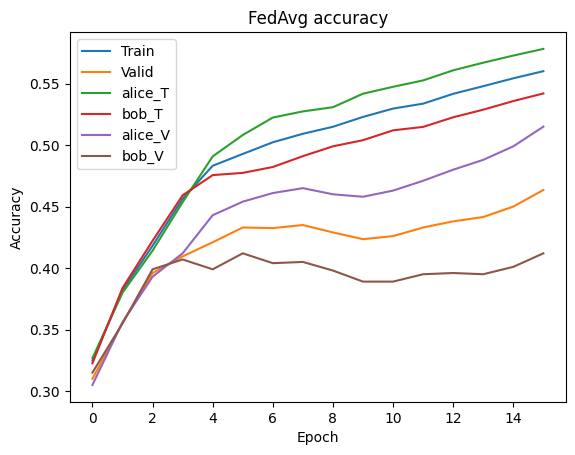

In [24]:
from matplotlib import pyplot as plt

# Draw accuracy values for training & validation
plt.plot(history["global_history"]["multiclassaccuracy"])
plt.plot(history["global_history"]["val_multiclassaccuracy"])
plt.plot(history["local_history"]["alice_train_multiclassaccuracy"])
plt.plot(history["local_history"]["bob_train_multiclassaccuracy"])
plt.plot(history["local_history"]["alice_val_eval_multiclassaccuracy"])
plt.plot(history["local_history"]["bob_val_eval_multiclassaccuracy"])
plt.title("FedAvg accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Valid", "alice_T", "bob_T", "alice_V", "bob_V"], loc="upper left")
plt.show()

FedPer结果

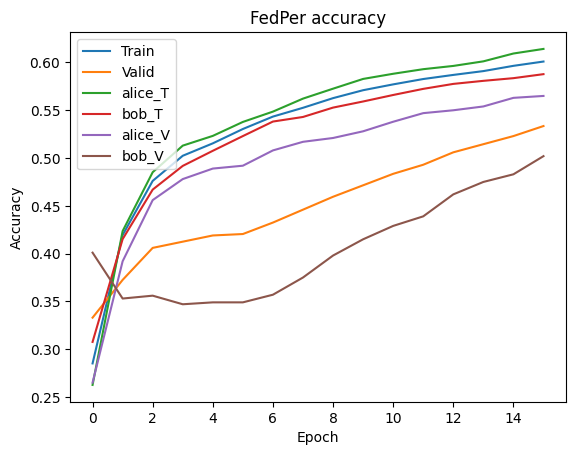

In [11]:
from matplotlib import pyplot as plt

# Draw accuracy values for training & validation
plt.plot(history["global_history"]["multiclassaccuracy"])
plt.plot(history["global_history"]["val_multiclassaccuracy"])
plt.plot(history["local_history"]["alice_train_multiclassaccuracy"])
plt.plot(history["local_history"]["bob_train_multiclassaccuracy"])
plt.plot(history["local_history"]["alice_val_eval_multiclassaccuracy"])
plt.plot(history["local_history"]["bob_val_eval_multiclassaccuracy"])
plt.title("FedPer accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Valid", "alice_T", "bob_T", "alice_V", "bob_V"], loc="upper left")
plt.show()

使用10个客户端进行100个epoch的FedPer和FedAvg对比实验

In [13]:
sf.shutdown()
sf.init(
    [
        "client1",
        "client2",
        "client3",
        "client4",
        "client5",
        "client6",
        "client7",
        "client8",
        "client9",
        "client10",
        "charlie",
    ],
    address="local",
)
(
    client1,
    client2,
    client3,
    client4,
    client5,
    client6,
    client7,
    client8,
    client9,
    client10,
    charlie,
) = (
    sf.PYU(name)
    for name in [
        "client1",
        "client2",
        "client3",
        "client4",
        "client5",
        "client6",
        "client7",
        "client8",
        "client9",
        "client10",
        "charlie",
    ]
)

(train_data, train_label), (test_data, test_label) = load_cifar10(
    parts={
        client1: 0.1,
        client2: 0.1,
        client3: 0.1,
        client4: 0.1,
        client5: 0.1,
        client6: 0.1,
        client7: 0.1,
        client8: 0.1,
        client9: 0.1,
        client10: 0.1,
    },
    is_torch=True,
    num_classes_per_client=4,
)

2023-12-09 02:47:52,888	INFO worker.py:1538 -- Started a local Ray instance.


Files already downloaded and verified
Files already downloaded and verified
the sample size of client1 is 5000, random classes are [2 8 4 9].
the sample size of client2 is 5000, random classes are [2 9 6 4].
the sample size of client3 is 5000, random classes are [4 1 5 0].
the sample size of client4 is 5000, random classes are [5 4 1 2].
the sample size of client5 is 5000, random classes are [3 8 4 9].
the sample size of client6 is 5000, random classes are [9 5 2 4].
the sample size of client7 is 5000, random classes are [8 1 7 0].
the sample size of client8 is 5000, random classes are [8 5 0 2].
the sample size of client9 is 5000, random classes are [8 6 9 0].
the sample size of client10 is 5000, random classes are [8 4 7 2].
the sample size of client1 is 1000, random classes are [2 8 4 9].
the sample size of client2 is 1000, random classes are [2 9 6 4].
the sample size of client3 is 1000, random classes are [4 1 5 0].
the sample size of client4 is 1000, random classes are [5 4 1 2].

先使用FedPer进行训练

In [ ]:
device_list = [
    client1,
    client2,
    client3,
    client4,
    client5,
    client6,
    client7,
    client8,
    client9,
    client10,
]
server = charlie
aggregator = SecureAggregator(server, device_list)


# spcify params
fl_model = FLModel(
    server=server,
    device_list=device_list,
    model=model_def,
    aggregator=aggregator,
    strategy="fed_per",  # fl strategy
    backend="torch",
    Kp=2,
)

In [ ]:
history = fl_model.fit(
    train_data,
    train_label,
    validation_data=(test_data, test_label),
    epochs=100,
    batch_size=128,
    aggregate_freq=4,
)

FedAvg训练

In [ ]:
# spcify params
fl_model_avg = FLModel(
    server=server,
    device_list=device_list,
    model=model_def,
    aggregator=aggregator,
    strategy="fed_avg_w",
    backend="torch",
)
history_ = fl_model_avg.fit(
    train_data,
    train_label,
    validation_data=(test_data, test_label),
    epochs=100,
    batch_size=128,
    aggregate_freq=4,
)

可以看到在每个客户端只有4类图像样本的情况下，使用FedPer个性化联邦策略训练的全局客户端平均精度优于FedAvg策略。

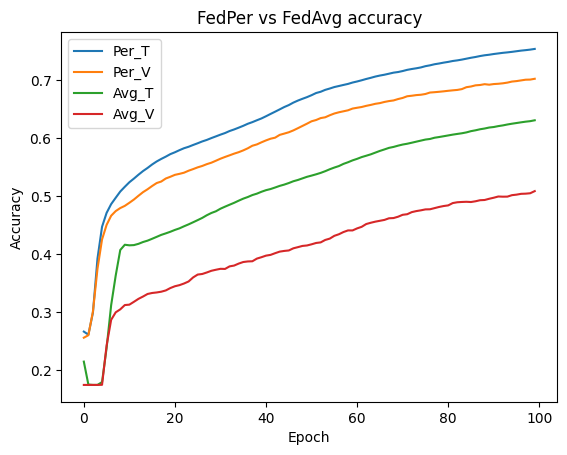

In [34]:
from matplotlib import pyplot as plt

# Draw accuracy values for training & validation
plt.plot(history["global_history"]["multiclassaccuracy"])
plt.plot(history["global_history"]["val_multiclassaccuracy"])
plt.plot(history_["global_history"]["multiclassaccuracy"])
plt.plot(history_["global_history"]["val_multiclassaccuracy"])
plt.title("FedPer vs FedAvg accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Per_T", "Per_V", "Avg_T", "Avg_V"], loc="upper left")
plt.show()